In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing
from scipy.stats import iqr
import tensorflow as tf

# Pre processing

In [2]:
path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=100000) # just read first 100000 events

In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []
# more_data
data2 = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    # cluster jets from the particles in one observation
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)): # for each jet get (px, py, pz, e)
        jet = []
        jet.append(jets[k].px)
        jet.append(jets[k].py)
        jet.append(jets[k].pz)
        jet.append(jets[k].e)
        # might be useful later for bump hunt
        jet.append(jets[k].pt)
        jet.append(jets[k].eta)
        jet.append(jets[k].phi)
        jet.append(jets[k].mass)
        data.append(jet)

In [7]:
loaded_data = data
# data = loaded_data

In [8]:
data = np.array(data)
data = data[:,4:]  # just keep px, py, pz, e
data.shape

(1477373, 4)

In [9]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [10]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [11]:
# get the inverse iqr proportion for each feature used to scale their weights in the loss function
iqr_prop = iqr(x_train,axis = 0)
max_iqr = max(iqr_prop)
iqr_prop = np.array(iqr_prop) / max_iqr
print(iqr_prop)

[0.03103692 0.89715134 1.         0.04950277]


# VAE Model

In [12]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape, LeakyReLU, ELU
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

Using TensorFlow backend.


In [13]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [14]:
inter_dim_1 = 32
inter_dim_2 = 16
final_dim = 8
latent_dim = 2
input_dim = 4

In [15]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim_1, activation='relu')(x)
h2 = Dense(inter_dim_2, activation='relu')(h1)
h3 = Dense(final_dim, activation='relu')(h2)
encoding = Dense(latent_dim, activation='tanh')(h3)

In [16]:
# decoder
decoder_h3 = Dense(final_dim, activation='relu')
decoder_h2 = Dense(inter_dim_2, activation='relu')
decoder_h1 = Dense(inter_dim_1, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h3_decoded = decoder_h3(encoding)
h2_decoded = decoder_h2(h3_decoded)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [17]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [18]:
mse = keras.losses.MeanSquaredError()
def ae_loss(x, y):
    mse_loss = 0.25 * (iqr_prop[0]*(x[::,0] - y[::,0])**2 + iqr_prop[1]*(x[::,1] - y[::,1])**2 + iqr_prop[2]*(x[::,2] - y[::,2])**2 + iqr_prop[3]*(x[::,3] - y[::,3])**2)
    # mse_loss = mse(x,y)
    return mse_loss

vae.compile(optimizer='adam', loss=ae_loss)

In [19]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_6 (Dense)              (None, 16)                144     

# Train

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
batch_size = 1000
epochs = 200

In [22]:
x_train.shape

(1181898, 4)

In [23]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

In [24]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val),
               callbacks=my_callbacks)

Train on 1181898 samples, validate on 147737 samples
Epoch 1/200
1181898/1181898 [==============================] - 6s 5us/step - loss: 0.0490 - val_loss: 0.0166
Epoch 2/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0160 - val_loss: 0.0147
Epoch 3/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0114 - val_loss: 0.0093
Epoch 4/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0081 - val_loss: 0.0071
Epoch 5/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0068 - val_loss: 0.0064
Epoch 6/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0062 - val_loss: 0.0062
Epoch 7/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0059 - val_loss: 0.0057
Epoch 8/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0055 - val_loss: 0.0053
Epoch 9/200
1181898/1181898 [==============================] - 5s 4us/step 

1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 76/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 77/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 78/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 79/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 80/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 81/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 82/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 83/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 84/200
1181898/11

# Visualization

In [25]:
import matplotlib.pyplot as plt

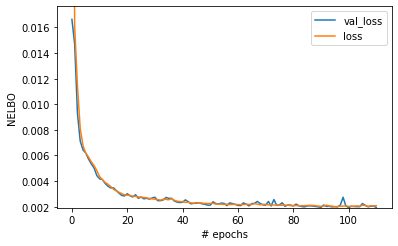

In [26]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [27]:
predictions = vae.predict(x_test)

In [28]:
# mse on test set
p = vae.predict(x_train)
print(mse(p, x_train))

tf.Tensor(0.030015439, shape=(), dtype=float32)


In [29]:
distr = (x_test - predictions) / x_test

In [30]:
px_pred = [row[0] for row in predictions]
py_pred = [row[1] for row in predictions]
pz_pred = [row[2] for row in predictions]
e_pred = [row[3] for row in predictions]

In [31]:
px = [row[0] for row in x_test]
py = [row[1] for row in x_test]
pz = [row[2] for row in x_test]
e = [row[3] for row in x_test]

In [32]:
overall_distr = K.flatten(distr)
overall_pred = K.flatten(predictions)
overall_input = K.flatten(x_test)

(array([ 3282.,  3295.,  3382.,  3572.,  3657.,  3586.,  3606.,  3561.,
         3353.,  3367.,  3067.,  3110.,  3474., 28554., 51007., 87138.,
        65404., 26376., 10210.,  7476.,  4804.,  4546.,  4317.,  4392.,
         4842.,  4662.,  4215.,  4015.,  3667.,  3758.,  3760.,  3784.,
         3826.,  3576.,  3408.,  3497.,  3486.,  3669.,  3683.,  3601.,
         3781.,  3857.,  3960.,  4168.,  4246.,  4182.,  4246.,  4308.,
         4270.]),
 array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
        -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
        -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
        -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0.2244898 ,
        -0.18367347, -0.14285714, -0.10204082, -0.06122449, -0.02040816,
         0.02040816,  0.06122449,  0.10204082,  0.14285714,  0.18367347,
         0.2244898 ,  0.26530612,  0.30612245,  0.34693878,  0.3877551 ,
         0.42857143,  0.46938776,  0.51

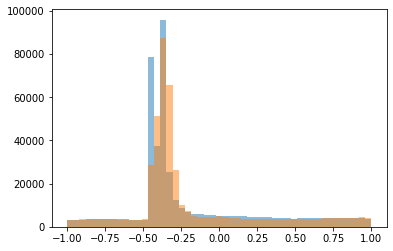

In [33]:
# overall pred vs input
bins = np.linspace(-1, 1, 50)
plt.hist(overall_input, bins=bins,alpha=0.5)
plt.hist(overall_pred, bins=bins,alpha=0.5)

(array([   473.,    524.,    582.,    672.,    868.,    996.,   1178.,
          1486.,   1915.,   2487.,   3515.,   5386.,  10542.,  32160.,
        382095.,  97006.,  21122.,   6704.,   1674.,   1019.,    843.,
          1020.,    943.,    813.,    836.,    737.,    612.,    474.,
           408.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

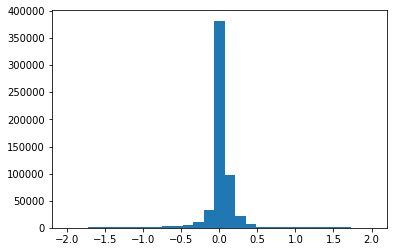

In [34]:
# overall distr
bins = np.linspace(-2, 2, 30)
plt.hist(overall_distr, bins=bins)

## Stacking output (orange) over input (blue) for px, py, pz, E

(array([71., 67., 57., 50., 50., 40., 39., 30., 31., 30., 20., 26., 24.,
        20., 18., 27., 19., 17., 17., 10., 13.,  7.,  1.,  2.,  2.,  5.,
         4.,  0.,  3.,  0.,  0.,  0.,  2.,  1.,  1.,  5.,  1.,  2.,  2.]),
 array([-0.2       , -0.18974359, -0.17948718, -0.16923077, -0.15897436,
        -0.14871795, -0.13846154, -0.12820513, -0.11794872, -0.10769231,
        -0.0974359 , -0.08717949, -0.07692308, -0.06666667, -0.05641026,
        -0.04615385, -0.03589744, -0.02564103, -0.01538462, -0.00512821,
         0.00512821,  0.01538462,  0.02564103,  0.03589744,  0.04615385,
         0.05641026,  0.06666667,  0.07692308,  0.08717949,  0.0974359 ,
         0.10769231,  0.11794872,  0.12820513,  0.13846154,  0.14871795,
         0.15897436,  0.16923077,  0.17948718,  0.18974359,  0.2       ]),
 <a list of 39 Patch objects>)

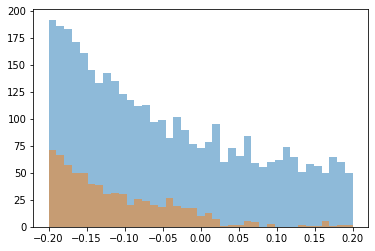

In [35]:
# px
bins = np.linspace(-0.2, 0.2, 40)
plt.hist(px, bins=bins,alpha=0.5)
plt.hist(px_pred, bins=bins,alpha=0.5)

In [36]:
print(mse(px,px_pred))

tf.Tensor(0.06615099, shape=(), dtype=float32)


(array([541., 606., 566., 588., 595., 625., 613., 564., 606., 615., 615.,
        618., 573., 640., 627., 594., 615., 697., 722., 751., 791., 824.,
        782., 727., 692., 632., 615., 629., 611., 553., 549., 605., 557.,
        495., 493., 475., 485., 539., 475.]),
 array([-0.2       , -0.18974359, -0.17948718, -0.16923077, -0.15897436,
        -0.14871795, -0.13846154, -0.12820513, -0.11794872, -0.10769231,
        -0.0974359 , -0.08717949, -0.07692308, -0.06666667, -0.05641026,
        -0.04615385, -0.03589744, -0.02564103, -0.01538462, -0.00512821,
         0.00512821,  0.01538462,  0.02564103,  0.03589744,  0.04615385,
         0.05641026,  0.06666667,  0.07692308,  0.08717949,  0.0974359 ,
         0.10769231,  0.11794872,  0.12820513,  0.13846154,  0.14871795,
         0.15897436,  0.16923077,  0.17948718,  0.18974359,  0.2       ]),
 <a list of 39 Patch objects>)

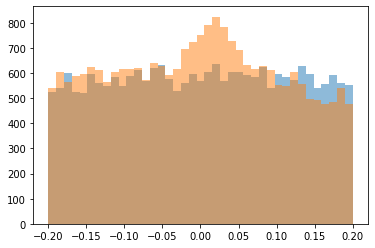

In [37]:
# py
bins = np.linspace(-0.2, 0.2, 40)
plt.hist(py, bins=bins,alpha=0.5)
plt.hist(py_pred, bins=bins,alpha=0.5)

In [38]:
print(mse(py,py_pred))

tf.Tensor(0.0033391917, shape=(), dtype=float32)


(array([1059., 1155., 1089., 1116., 1042., 1123., 1100., 1151., 1063.,
        1076., 1068., 1075., 1104., 1098., 1090., 1050., 1029., 1121.,
        1117., 1072., 1086., 1137., 1077., 1108., 1097., 1095., 1120.,
        1092., 1137., 1078., 1113., 1080., 1119., 1097., 1122., 1054.,
        1124., 1067., 1016.]),
 array([-0.5       , -0.47435897, -0.44871795, -0.42307692, -0.3974359 ,
        -0.37179487, -0.34615385, -0.32051282, -0.29487179, -0.26923077,
        -0.24358974, -0.21794872, -0.19230769, -0.16666667, -0.14102564,
        -0.11538462, -0.08974359, -0.06410256, -0.03846154, -0.01282051,
         0.01282051,  0.03846154,  0.06410256,  0.08974359,  0.11538462,
         0.14102564,  0.16666667,  0.19230769,  0.21794872,  0.24358974,
         0.26923077,  0.29487179,  0.32051282,  0.34615385,  0.37179487,
         0.3974359 ,  0.42307692,  0.44871795,  0.47435897,  0.5       ]),
 <a list of 39 Patch objects>)

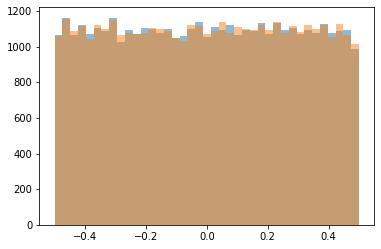

In [39]:
# pz
bins = np.linspace(-0.5, 0.5, 40)
plt.hist(pz, bins=bins,alpha=0.5)
plt.hist(pz_pred, bins=bins,alpha=0.5)

In [40]:
print(mse(pz,pz_pred))

tf.Tensor(8.334094e-05, shape=(), dtype=float32)


(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.2000e+01, 2.3000e+01, 3.2000e+01, 6.1000e+01, 1.6721e+04,
        2.9961e+04, 3.2288e+04, 2.5384e+04, 9.9490e+03, 3.6490e+03,
        3.2030e+03, 2.3520e+03, 1.4700e+03, 3.7800e+02, 2.3400e+02,
        1.9600e+02, 1.1400e+02, 8.8000e+01, 5.1000e+01, 2.1000e+01,
        5.0000e+00, 1.0000e+00, 5.0000e+00, 1.0000e+00, 5.0000e+00,
        5.0000e+00, 5.0000e+00, 3.0000e+00, 6.0000e+00, 6.0000e+00,
        1.0000e+01, 4.0000e+00, 1.9000e+01, 2.0000e+01]),
 array([-0.6       , -0.57692308, -0.55384615, -0.53076923, -0.50769231,
        -0.48461538, -0.46153846, -0.43846154, -0.41538462, -0.39230769,
        -0.36923077, -0.34615385, -0.32307692, -0.3       , -0.27692308,
        -0.25384615, -0.23076923, -0.20769231, -0.18461538, -0.16153846,
        -0.13846154, -0.11538462, -0.09230769, -0.06923077, -0.04615385,
        -0.02307692,  0.        ,  0.02307692,  0.04615385,  0.06923077,
         0.09230769,  0.1153

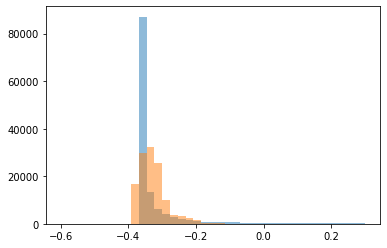

In [41]:
# E
bins = np.linspace(-0.6,0.3, 40)
plt.hist(e, bins=bins,alpha=0.5)
plt.hist(e_pred, bins=bins,alpha=0.5)

In [42]:
print(mse(e,e_pred))

tf.Tensor(0.054726988, shape=(), dtype=float32)


In [43]:
d_px = [row[0] for row in distr]
d_py = [row[1] for row in distr]
d_pz = [row[2] for row in distr]
d_e = [row[3] for row in distr]

## Distribution of (input - output) / input

In [44]:
bins = np.linspace(-2, 2, 30)

(array([1.2800e+02, 1.5700e+02, 1.7100e+02, 1.9400e+02, 2.9000e+02,
        3.2800e+02, 3.7900e+02, 4.9200e+02, 5.9600e+02, 7.6700e+02,
        1.0380e+03, 1.5570e+03, 3.0230e+03, 1.1734e+04, 5.8592e+04,
        5.2352e+04, 1.0548e+04, 8.5400e+02, 6.2000e+01, 2.3000e+01,
        2.0000e+01, 4.5000e+01, 8.7000e+01, 1.4600e+02, 1.9200e+02,
        2.5500e+02, 2.0900e+02, 1.6200e+02, 1.2400e+02]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

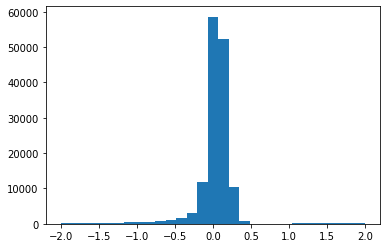

In [45]:
plt.hist(d_px, bins=bins)

(array([7.40000e+01, 8.80000e+01, 9.10000e+01, 1.14000e+02, 1.38000e+02,
        1.69000e+02, 1.94000e+02, 2.57000e+02, 3.78000e+02, 4.86000e+02,
        8.00000e+02, 1.14000e+03, 1.89300e+03, 4.99600e+03, 1.19704e+05,
        5.20800e+03, 2.53200e+03, 1.70500e+03, 1.03100e+03, 7.61000e+02,
        7.26000e+02, 9.39000e+02, 7.37000e+02, 4.31000e+02, 3.24000e+02,
        2.09000e+02, 1.61000e+02, 1.30000e+02, 9.80000e+01]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

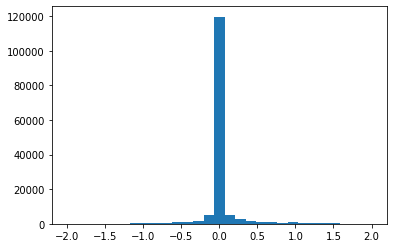

In [46]:
plt.hist(d_py, bins=bins)

(array([8.00000e+00, 1.00000e+01, 7.00000e+00, 7.00000e+00, 1.70000e+01,
        2.30000e+01, 2.70000e+01, 3.20000e+01, 5.50000e+01, 6.90000e+01,
        1.21000e+02, 2.09000e+02, 4.91000e+02, 2.57700e+03, 1.40414e+05,
        2.37000e+03, 4.88000e+02, 1.88000e+02, 1.37000e+02, 7.50000e+01,
        4.30000e+01, 2.80000e+01, 2.60000e+01, 1.90000e+01, 2.90000e+01,
        1.50000e+01, 1.00000e+01, 5.00000e+00, 7.00000e+00]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

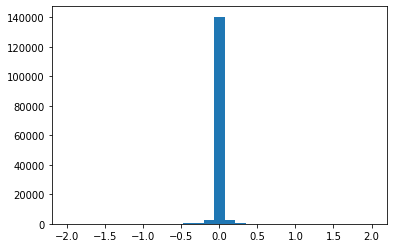

In [47]:
plt.hist(d_pz, bins=bins)

(array([2.6300e+02, 2.6900e+02, 3.1300e+02, 3.5700e+02, 4.2300e+02,
        4.7600e+02, 5.7800e+02, 7.0500e+02, 8.8600e+02, 1.1650e+03,
        1.5560e+03, 2.4800e+03, 5.1350e+03, 1.2853e+04, 6.3385e+04,
        3.7076e+04, 7.5540e+03, 3.9570e+03, 4.4400e+02, 1.6000e+02,
        5.4000e+01, 8.0000e+00, 9.3000e+01, 2.1700e+02, 2.9100e+02,
        2.5800e+02, 2.3200e+02, 1.7700e+02, 1.7900e+02]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

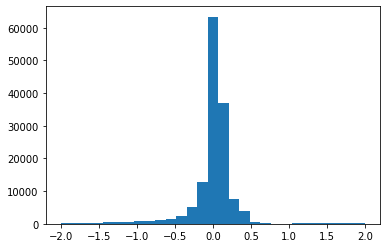

In [48]:
plt.hist(d_e, bins=bins)

# Anomaly Detection

In [49]:
from sklearn.metrics import mean_squared_error

In [50]:
all_data = np.concatenate((x_train, x_val, x_test))
all_pred = vae.predict(all_data)

In [51]:
# get the mse of all predictions
errors = (np.square(all_data - all_pred)).mean(axis=1)
mse_thresh = np.quantile(errors,0.95)

In [52]:
# all the inputs that had high mse
data_df = pd.DataFrame(loaded_data)
data_df.columns = ['px','py','pz','e','pt','eta','phi','mass']
data_df["mse"] = errors
data_df["outlier"] = 0

In [53]:
data_df.loc[data_df["mse"] > mse_thresh, "outlier"] = 1

In [54]:
data_df.loc[data_df["outlier"] == 1]

,px,py,pz,e,pt,eta,phi,mass,mse,outlier
1,611.088616,716.513394,1558.330438,1871.941989,941.711601,1.277667,0.864642,434.686458,0.261187,1
2,496.094722,-18.711175,1789.405584,1858.085692,496.447461,1.994018,-0.037699,63.639718,0.582231,1
19,1033.836179,-637.488365,635.714060,1392.484342,1214.581681,0.502044,-0.552554,244.277745,0.577113,1
49,878.307028,1182.994300,1984.545138,2597.609007,1473.397009,1.106737,0.932149,798.908253,0.187622,1
66,-617.868726,-93.854432,-329.867437,718.349229,624.956332,-0.505960,-2.990845,129.006484,0.521215,1
...,...,...,...,...,...,...,...,...,...,...
1477300,444.632974,226.935994,412.811647,693.639838,499.197784,0.753575,0.471925,248.041008,1.519532,1
1477316,-1183.348263,266.011832,2203.505011,2527.528651,1212.878974,1.358549,2.920472,248.779701,0.276423,1
1477317,676.606446,-117.854251,-445.422516,820.026832,686.793934,-0.610011,-0.172454,48.547705,0.390803,1
1477318,479.824070,-174.941974,1241.042099,1343.000728,510.720895,1.620908,-0.349618,51.279938,0.468894,1


In [57]:
mass_mu = data_df.mass.mean()
mass_sd = data_df.mass.std()

89.51971763141093

In [58]:
data_df.loc[data_df["mass"] >= mass_mu + 5 * mass_sd]

,px,py,pz,e,pt,eta,phi,mass,mse,outlier
49,878.307028,1182.994300,1984.545138,2597.609007,1473.397009,1.106737,0.932149,798.908253,0.187622,1
128,-1067.975875,467.865279,-364.864530,1356.013696,1165.963288,-0.308035,2.728690,588.367768,0.046370,0
236,-93.493208,-1426.434859,-161.979288,1518.931564,1429.495501,-0.113071,-1.636246,487.297053,0.012391,0
253,1252.130447,-347.873350,-162.329283,1434.715847,1299.556279,-0.124589,-0.270991,585.843189,0.008580,0
304,-847.244728,-1100.560431,-912.083428,1833.281801,1388.904925,-0.616827,-2.226868,774.576717,0.038996,0
...,...,...,...,...,...,...,...,...,...,...
1476746,1143.612124,-868.394361,-876.121810,1776.588488,1435.951760,-0.577495,-0.649454,571.594062,0.027818,0
1476760,-1233.497964,235.167099,409.361365,1445.194826,1255.715251,0.320484,2.953203,586.677565,0.028730,0
1477048,-1064.740867,813.933454,-359.135169,1480.445664,1340.209230,-0.264862,2.488912,516.314356,0.009778,0
1477164,1454.088404,-397.482521,689.726837,1841.289398,1507.436712,0.442924,-0.266836,801.410067,0.144629,0
